In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from dask.distributed import Client
client = Client() 

In [2]:
pth = '../data'
chp = xr.open_dataset(f'{pth}/chirps-v2.0.1981-2020.days_p05.nc', chunks={'time': 30})
bsl = xr.open_dataset(f'{pth}/pr_day_CNRM-CM6-1_historical_r1i1p1f2_gr_19500101-20141231_v20180917.nc', chunks={'time': 30})
ssp = xr.open_dataset(f'{pth}/pr_day_CNRM-CM6-1_ssp245_r1i1p1f2_gr_20150101-21001231_v20190219.nc', chunks={'time': 30})

In [3]:
# Ubah nama longitude dan latitude pada data CHIRPS menjadi lon dan lat
chp = chp.rename({'longitude': 'lon', 'latitude': 'lat', 'precip':'pr'})

In [4]:
# Cakupan area
lon1, lon2, lat1, lat2 = 108, 123, -4, 8
# Potong data sesuai cakupan area
chp = chp.sel(lon=slice(lon1, lon2), lat=slice(lat1, lat2))
bsl = bsl.sel(lon=slice(lon1, lon2), lat=slice(lat1, lat2))
ssp = ssp.sel(lon=slice(lon1, lon2), lat=slice(lat1, lat2))
# Periode waktu untuk koreksi
t1, t2 = '1981-01-01', '2010-12-31'
t3, t4 = '2021-01-01', '2050-12-31'
# Potong data sesuai periode waktu
chp = chp.sel(time=slice(t1, t2))
bsl = bsl.sel(time=slice(t1, t2))
ssp = ssp.sel(time=slice(t3, t4))

In [5]:
# Interpolasi CNRM-CM6-1 ke resolusi CHIRPS
resample_bsl = bsl.interp(coords = {
    'lat' : chp['lat'].values,
    'lon' : chp['lon'].values
}, method = 'linear', kwargs={"fill_value": "extrapolate"})

resample_ssp = ssp.interp(coords = {
    'lat' : chp['lat'].values,
    'lon' : chp['lon'].values
}, method = 'linear', kwargs={"fill_value": "extrapolate"})

In [6]:
# Kalikan dengan 86400 untuk mengubah satuan curah hujan dari kg/m2/detik menjadi mm/hari
# dan mengubah nilai curah hujan yang <1 mm/hari menjadi 0
# Baseline
resample_bsl['pr'] = resample_bsl['pr'] * 86400
resample_bsl['pr'] = xr.where(resample_bsl['pr'] < 1, 0, resample_bsl['pr'])
# SSP 245
resample_ssp['pr'] = resample_ssp['pr'] * 86400
resample_ssp['pr'] = xr.where(resample_ssp['pr'] < 1, 0, resample_ssp['pr'])

## Metode Delta

In [7]:
# Menghitung rataan semua waktu
# Baseline
bsl_mean = resample_bsl.mean(dim='time')
# SSP 245
ssp_mean = resample_ssp.mean(dim='time')

# Menghitung rasio rataan SSP 245 terhadap baseline
ratio = ssp_mean / bsl_mean

# Kalikan rasio dengan data CHIRPS
ssp_corrected = ratio * chp

# Transpose with time as first dimension
ssp_corrected = ssp_corrected.transpose('time', 'lat', 'lon')

# Mengubah waktu historis menjadi skenario SSP
ssp_corrected = ssp_corrected.assign(time=ssp.time)

In [8]:
# Jumlahkan curah hujan setiap bulan untuk setiap tahun
ssp_corrected_monthly = ssp_corrected.resample(time='M').sum(skipna=False)

# Rata-rata klimatologi bulanan
ssp_corrected_monthly_mean = ssp_corrected_monthly.groupby('time.month').mean(dim='time')

/Users/agungbaruna/miniconda3/envs/wrf/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


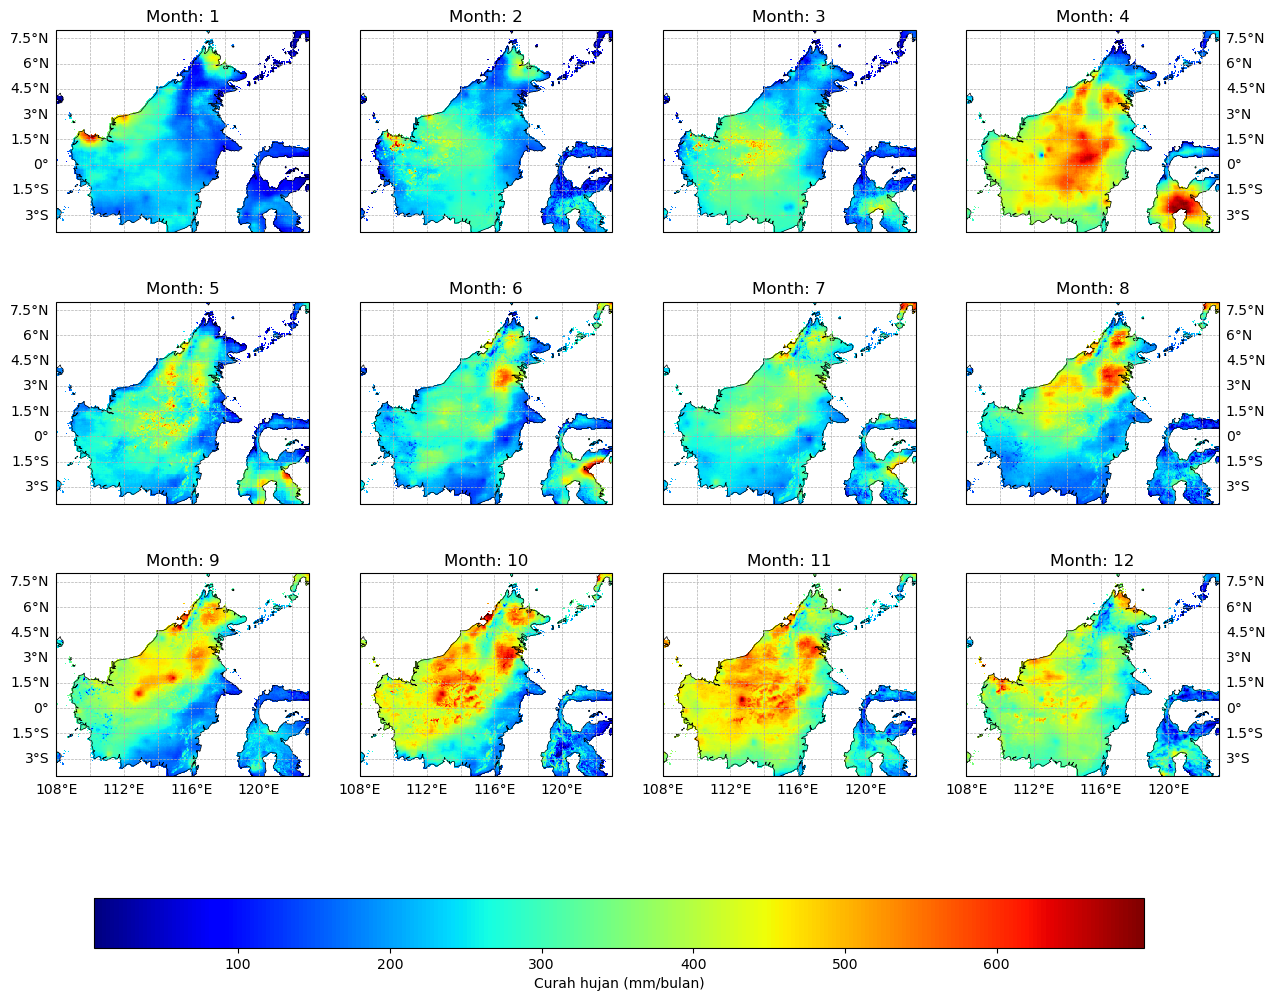

In [10]:
# Create a subplot of spatial plots for each month
fig, axes = plt.subplots(3, 4, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
for month, ax in zip(range(1, 13), axes.ravel()):
    month_data = ssp_corrected_monthly_mean.sel(month=month)
    month_data = month_data['pr']
    month_data.plot.imshow(ax=ax, cmap='jet', add_colorbar=False, transform=ccrs.PlateCarree())

    # Menambahkan judul grafik dan garis pantai
    ax.set_title(f'Month: {month}')
    ax.coastlines(linewidth=0.5)

    # Menambahkan garis lintang dan bujur
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)

    # Menghilangkan label untuk beberapa plot agar tidak terlalu padat
    if month in [2, 3, 4, 6, 7, 8, 10, 11, 12]:
        gl.left_labels = False
    if month in [1, 2, 3, 4, 5, 6, 7, 8]:
        gl.bottom_labels = False
    if month not in [4, 8, 12]:
        gl.right_labels = False
    gl.top_labels = False

# Menambahkan colorbar
cbar_ax = fig.add_axes([0.15, -0.05, 0.7, 0.05])
fig.colorbar(ax.images[0], cax=cbar_ax, orientation='horizontal', label='Curah hujan (mm/bulan)')

plt.show()

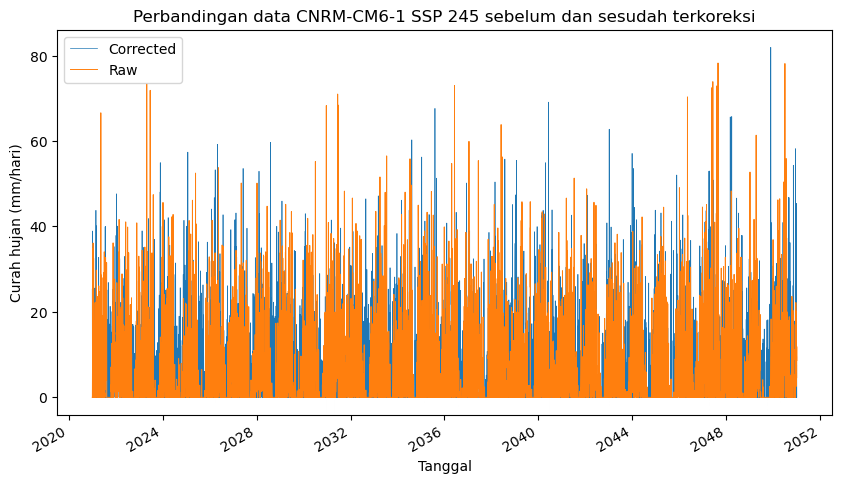

In [88]:
# Membuat plot
fig, ax = plt.subplots(figsize=(10, 5))
# Memilih data untuk setiap bulan
lat, lon = -3.3224, 114.5960
ssp_corrected.pr.sel(lat=lat, lon=lon, method='nearest').plot(ax=ax, label='Corrected', linewidth=0.5)
resample_ssp.pr.sel(lat=lat, lon=lon, method='nearest').plot(ax=ax, label='Raw', linewidth=0.7)
# Menambahkan judul grafik
ax.set_title('Perbandingan data CNRM-CM6-1 SSP 245 sebelum dan sesudah terkoreksi')
# Menambahkan label sumbu x dan y
ax.set_xlabel('Tanggal')
ax.set_ylabel('Curah hujan (mm/hari)')
# Menambahkan legend
ax.legend()
plt.show()

## Metode Distribusi Statistik

In [9]:
# 1. Menghitung peluang kejadian tidak hujan (CH < 1) untuk setiap grid dari variabel `resample_bsl`
resample_bsl_prob = (resample_bsl.pr < 1).mean(dim='time')

non_nan_mask = ~np.isnan(chp.pr)
chp_prob = (chp.pr < 1).where(non_nan_mask).mean(dim='time')

In [10]:
# 2. Menghitung rataan curah hujan >= 1 mm
resample_bsl_mean = resample_bsl.pr.where(resample_bsl.pr >= 1).mean(dim='time')
chp_mean = chp.pr.where(chp.pr >= 1).mean(dim='time')

In [11]:
# 3. Menghitung nilai ln(x_bar)
resample_bsl_mean_ln = np.log(resample_bsl_mean)
chp_mean_ln = np.log(chp_mean)

In [12]:
# 4. Menghitung nilai rataan ln(x) pada curah hujan >= 1 mm
resample_bsl_ln = np.log(resample_bsl.pr.where(resample_bsl.pr >= 1))
chp_ln = np.log(chp.pr.where(chp.pr >= 1))

In [13]:
# 5. Menghitung nilai y
resample_bsl_y = resample_bsl_mean_ln - resample_bsl_ln.mean(dim='time')
chp_y = chp_mean_ln - chp_ln.mean(dim='time')

In [14]:
# 6. Menghitung nilai alpha
def alpha(y):
   if y <= 0.5772:
      return (0.5000876 + 0.1648852*y - 0.0544276*y**2) / y
   elif y <= 17:
      return (8.898919 + 9.05995*y + 0.9775373*y**2) / (17.79728*y + 11.968477*y**2 + y**3)
   else:
      return 1 / y
alpha_ufunc = np.vectorize(alpha)
resample_bsl_alpha = xr.apply_ufunc(alpha_ufunc, resample_bsl_y.compute())
chp_alpha = xr.apply_ufunc(alpha_ufunc, chp_y.compute())

In [15]:
# 7. Menghitung nilai beta
resample_bsl_beta = resample_bsl_mean / resample_bsl_alpha
chp_beta = chp_mean / chp_alpha

In [16]:
# 8. Buat CDF untuk setiap grid dengan parameter skala dan bentuk yang telah dihitung
from scipy.stats import gamma, linregress

# Fungsi untuk menghitung CDF
def calculate_cdf(shape, scale, x, prob):
    if x < 1:
        return prob
    else:
        cdf_values = gamma.cdf(x, a=shape, scale=scale) * (1 - prob) + prob
        return cdf_values
ufunc_calculate_cdf = np.vectorize(calculate_cdf)

# Informasi lokasi sebagai informasi untuk x_values
lat = resample_bsl['lat']
lon = resample_bsl['lon']
# Membuat array dari 0.1 hingga 50 dengan 100 data
rain_min, rain_max, counts = 0.1, 50, 100
x_values = np.linspace(rain_min, rain_max, counts)
# Create a 3D x_values array matching the shape of shape_variable and scale_variable
x_values_3d = np.tile(x_values, (len(lat), len(lon), 1))
# Create xarray DataArray for x_values_3d
x_values_3d = xr.DataArray(
    x_values_3d,
    dims=['lat', 'lon', 'time'],
    coords={'lat': lat, 'lon': lon, 'time': x_values}
)

# Transpose with time as first dimension
x_values_3d = x_values_3d.transpose('time', 'lat', 'lon')

In [17]:
# Baseline CNRM-CM6-1
resample_bsl_cdf = xr.apply_ufunc(
    ufunc_calculate_cdf,
    resample_bsl_beta,
    resample_bsl_alpha,
    x_values_3d,
    resample_bsl_prob,
    input_core_dims=[['lat', 'lon'], ['lat', 'lon'], ['time', 'lat', 'lon'], ['lat', 'lon']],  # Core dimensions of shape and scale
    dask='parallelized',  # Use Dask for parallelization if desired
    output_core_dims=[['time', 'lat', 'lon']],  # Core dimensions of the output
    output_sizes={'time': len(x_values)},  # Sizes of the output dimensions
    output_dtypes=[float],
    vectorize=True
)

# Historis CHIRPS
chp_cdf = xr.apply_ufunc(
    ufunc_calculate_cdf,
    chp_beta,
    chp_alpha,
    x_values_3d,
    chp_prob,
    input_core_dims=[['lat', 'lon'], ['lat', 'lon'], ['time', 'lat', 'lon'], ['lat', 'lon']],  # Core dimensions of shape and scale
    dask='parallelized',  # Use Dask for parallelization if desired
    output_core_dims=[['time', 'lat', 'lon']],  # Core dimensions of the output
    output_sizes={'time': len(x_values)},  # Sizes of the output dimensions
    output_dtypes=[float],
    vectorize=True
)

resample_bsl_cdf = resample_bsl_cdf.compute()
chp_cdf = chp_cdf.compute()

/var/folders/07/364wfdzx0jn80kb_yj8bd6gm0000gn/T/ipykernel_18020/1802752961.py:2: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  resample_bsl_cdf = xr.apply_ufunc(
/var/folders/07/364wfdzx0jn80kb_yj8bd6gm0000gn/T/ipykernel_18020/1802752961.py:17: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  chp_cdf = xr.apply_ufunc(
/Users/agungbaruna/miniconda3/envs/wrf/lib/python3.11/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 55.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/Users/agungbaruna/miniconda3/envs/wrf/lib/python3.11/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 55.05 MiB.
This may cause some slowdown.
Consider scattering data ahead of time an

Text(0, 0.5, 'Peluang Kumulatif')

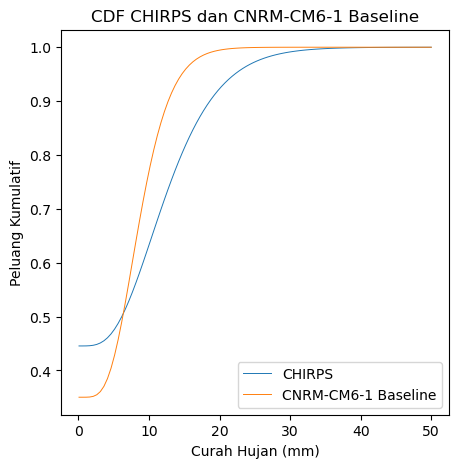

In [224]:
# Plot CDF
fig, ax = plt.subplots(figsize=(5, 5))

lat, lon = -3.3224, 114.5960
chp_cdf.sel(lat=lat, lon=lon, method='nearest').plot(ax=ax, label='CHIRPS', linewidth=0.7)
resample_bsl_cdf.sel(lat=lat, lon=lon, method='nearest').plot(ax=ax, label='CNRM-CM6-1 Baseline', linewidth=0.7)

ax.legend()
ax.set_title('CDF CHIRPS dan CNRM-CM6-1 Baseline')
ax.set_xlabel('Curah Hujan (mm)')
ax.set_ylabel('Peluang Kumulatif')

In [18]:
# 9. Mencari nilai Invers CDF 

# Fungsi untuk menghitung invers CDF
def calculate_invcdf(shape, scale, p, prob):
    if p < prob:
        return 0.0
    else:
        pr = (p - prob) / (1 - prob)
        invcdf_values = gamma.ppf(pr, a=shape, scale=scale)
        return invcdf_values
ufunc_calculate_invcdf = np.vectorize(calculate_invcdf)

p_min, p_max, counts = 0.00, 0.99, 100
# Informasi lokasi sebagai informasi untuk p_values
lat = resample_bsl['lat']
lon = resample_bsl['lon']
# Membuat array peluang dari 0 hingga 0.99 dengan 100 data
p_values = np.linspace(p_min, p_max, counts)
# Create a 3D x_values array matching the shape of shape_variable and scale_variable
p_values_3d = np.tile(p_values, (len(lat), len(lon), 1))
# Create xarray DataArray for x_values_3d
p_values_3d = xr.DataArray(
    p_values_3d,
    dims=['lat', 'lon', 'time'],
    coords={'lat': lat, 'lon': lon, 'time': p_values}
)

# Transpose with time as first dimension
p_values_3d = p_values_3d.transpose('time', 'lat', 'lon')

In [19]:
# Baseline CNRM-CM6-1
resample_bsl_invcdf = xr.apply_ufunc(
    ufunc_calculate_invcdf,
    resample_bsl_beta,
    resample_bsl_alpha,
    p_values_3d,
    resample_bsl_prob,
    input_core_dims=[['lat', 'lon'], ['lat', 'lon'], ['time', 'lat', 'lon'], ['lat', 'lon']],  # Core dimensions of shape and scale
    dask='parallelized',  # Use Dask for parallelization if desired
    output_core_dims=[['time', 'lat', 'lon']],  # Core dimensions of the output
    output_sizes={'time': len(p_values)},  # Sizes of the output dimensions
    output_dtypes=[float],
    vectorize=True
)

# Historis CHIRPS
chp_invcdf = xr.apply_ufunc(
    ufunc_calculate_invcdf,
    chp_beta,
    chp_alpha,
    p_values_3d,
    chp_prob,
    input_core_dims=[['lat', 'lon'], ['lat', 'lon'], ['time', 'lat', 'lon'], ['lat', 'lon']],  # Core dimensions of shape and scale
    dask='parallelized',  # Use Dask for parallelization if desired
    output_core_dims=[['time', 'lat', 'lon']],  # Core dimensions of the output
    output_sizes={'time': len(p_values)},  # Sizes of the output dimensions
    output_dtypes=[float],
    vectorize=True
)

resample_bsl_invcdf = resample_bsl_invcdf.compute()
chp_invcdf = chp_invcdf.compute()

/var/folders/07/364wfdzx0jn80kb_yj8bd6gm0000gn/T/ipykernel_18020/108252534.py:2: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  resample_bsl_invcdf = xr.apply_ufunc(
/var/folders/07/364wfdzx0jn80kb_yj8bd6gm0000gn/T/ipykernel_18020/108252534.py:17: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  chp_invcdf = xr.apply_ufunc(
/Users/agungbaruna/miniconda3/envs/wrf/lib/python3.11/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 55.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/Users/agungbaruna/miniconda3/envs/wrf/lib/python3.11/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 55.05 MiB.
This may cause some slowdown.
Consider scattering data ahead of tim

Text(0, 0.5, 'CHIRPS')

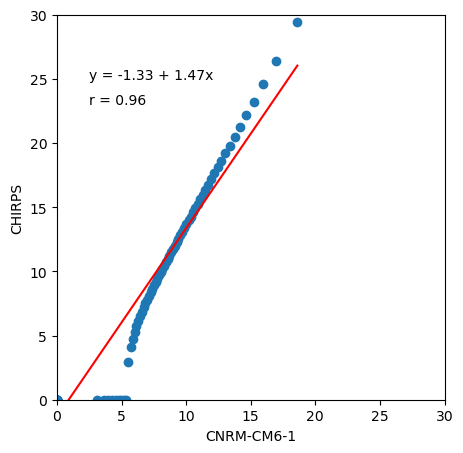

In [385]:
# Plot Invers CDF CHIRPS dan CNRM-CM6-1 Baseline, serta cantumkan persamaan regresi
# Perform linear regression
fit = linregress(bsl_sel, chp_sel)
bsl_fit = fit.slope * bsl_sel + fit.intercept

# Plot invers CDF
fig, ax = plt.subplots(figsize=(5, 5))

lat, lon = -3.3224, 114.5960

chp_sel = chp_invcdf.sel(lat=lat, lon=lon, method='nearest').values
bsl_sel = resample_bsl_invcdf.sel(lat=lat, lon=lon, method='nearest').values

# Plot scatter
ax.scatter(x = bsl_sel, y = chp_sel)

# Plot garis linier
ax.plot(bsl_sel, chp_fit, color = 'red')

# Menambahkan informasi persamaan regresi serta korelasi
regression_equation = f'y = {intercept:.2f} + {slope:.2f}x'
ax.text(2.5, 25, regression_equation)
ax.text(2.5, 23, f'r = {r_value:.2f}')

ax.set_xlim([0, 30]); ax.set_ylim([0, 30])
ax.set_xlabel('CNRM-CM6-1')
ax.set_ylabel('CHIRPS')

In [46]:
nlat = chp_invcdf.lat.values
nlon = chp_invcdf.lon.values

# Define a function to calculate the slope using linregress
def calculate_slope_invcdf(x, y):
    # Menyediakan array kosong sebanyak nlat x nlon
    slopes = np.empty((len(nlat), len(nlon)))
    # Meletakkan nilai slope untuk setiap grid ke array kosong
    for lat_idx, lat in enumerate(nlat):
        for lon_idx, lon in enumerate(nlon):
            fit = linregress(x[:, lat_idx, lon_idx], y[:, lat_idx, lon_idx])
            slopes[lat_idx, lon_idx] = fit.slope
    return slopes

# Calculate the slope for each latitude and longitude grid point
slope_invcdf = xr.apply_ufunc(
    calculate_slope_invcdf,
    resample_bsl_invcdf,
    chp_invcdf,
    input_core_dims=[['time', 'lat', 'lon'], ['time', 'lat', 'lon']],
    dask='parallelized',  # Use Dask for parallelization if desired
    output_core_dims=[['lat', 'lon']],  # Core dimensions of the output
    output_sizes={'lat': len(nlat), 'lon' : len(nlon)},  # Sizes of the output dimensions
    output_dtypes=[float],
    vectorize=True
)

/var/folders/07/364wfdzx0jn80kb_yj8bd6gm0000gn/T/ipykernel_18020/3608348967.py:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  slope_invcdf = xr.apply_ufunc(


In [35]:
# Menghitung data Baseline terkoreksi dengan nilai slope per grid
resample_bsl_corrected = resample_bsl.pr * slope_invcdf

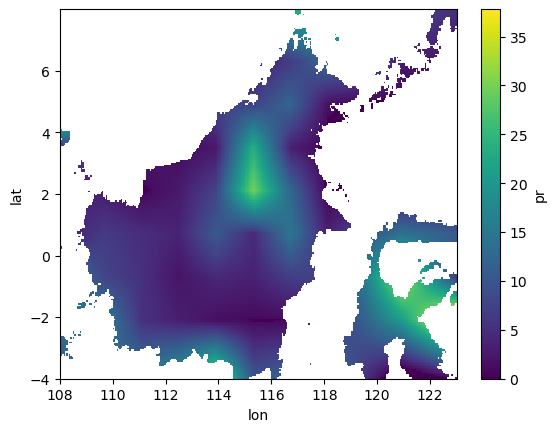

In [108]:
resample_bsl.pr[0].where(non_nan_mask[0]).plot()

In [105]:
non_nan_mask[0].values

array([[False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [112]:
# 10. Membandingkan data Baseline sebelum dan sesudah terkoreksi secara klimatologi

# Jumlahkan curah hujan setiap bulan untuk setiap tahun
resample_bsl_corrected_monthly = resample_bsl_corrected.resample(time='M').sum(skipna=False)
resample_bsl_landmask = resample_bsl.pr.where(non_nan_mask[0])
resample_bsl_monthly = resample_bsl_landmask.resample(time='M').sum(skipna=False)
chp_monthly = chp.pr.resample(time='M').sum(skipna=False)

# Rata-rata klimatologi bulanan
resample_bsl_corrected_monthly_mean = resample_bsl_corrected_monthly.groupby('time.month').mean(dim='time')
resample_bsl_monthly_mean = resample_bsl_monthly.groupby('time.month').mean(dim='time')
chp_monthly_mean = chp_monthly.groupby('time.month').mean(dim='time')

In [96]:
def create_clim_plot(data, label):
    # Create a subplot of spatial plots for each month
    fig, axes = plt.subplots(3, 4, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    for month, ax in zip(range(1, 13), axes.ravel()):
        month_data = data.sel(month=month)
        month_data.plot.imshow(ax=ax, cmap='jet', add_colorbar=False, transform=ccrs.PlateCarree(), vmin = 0, vmax = 800)

        # Menambahkan judul grafik dan garis pantai
        ax.set_title(f'Month: {month}')
        ax.coastlines(linewidth=0.5)

        # Menambahkan garis lintang dan bujur
        gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)

        # Menghilangkan label untuk beberapa plot agar tidak terlalu padat
        if month in [2, 3, 4, 6, 7, 8, 10, 11, 12]:
            gl.left_labels = False
        if month in [1, 2, 3, 4, 5, 6, 7, 8]:
            gl.bottom_labels = False
        if month not in [4, 8, 12]:
            gl.right_labels = False
        gl.top_labels = False

    # Menambahkan colorbar
    cbar_ax = fig.add_axes([0.11, 0.05, 0.8, 0.02])  # Left, bottom, width, height.
    fig.colorbar(ax.images[0], cax=cbar_ax, orientation='horizontal', label=label)
    
    plt.show()

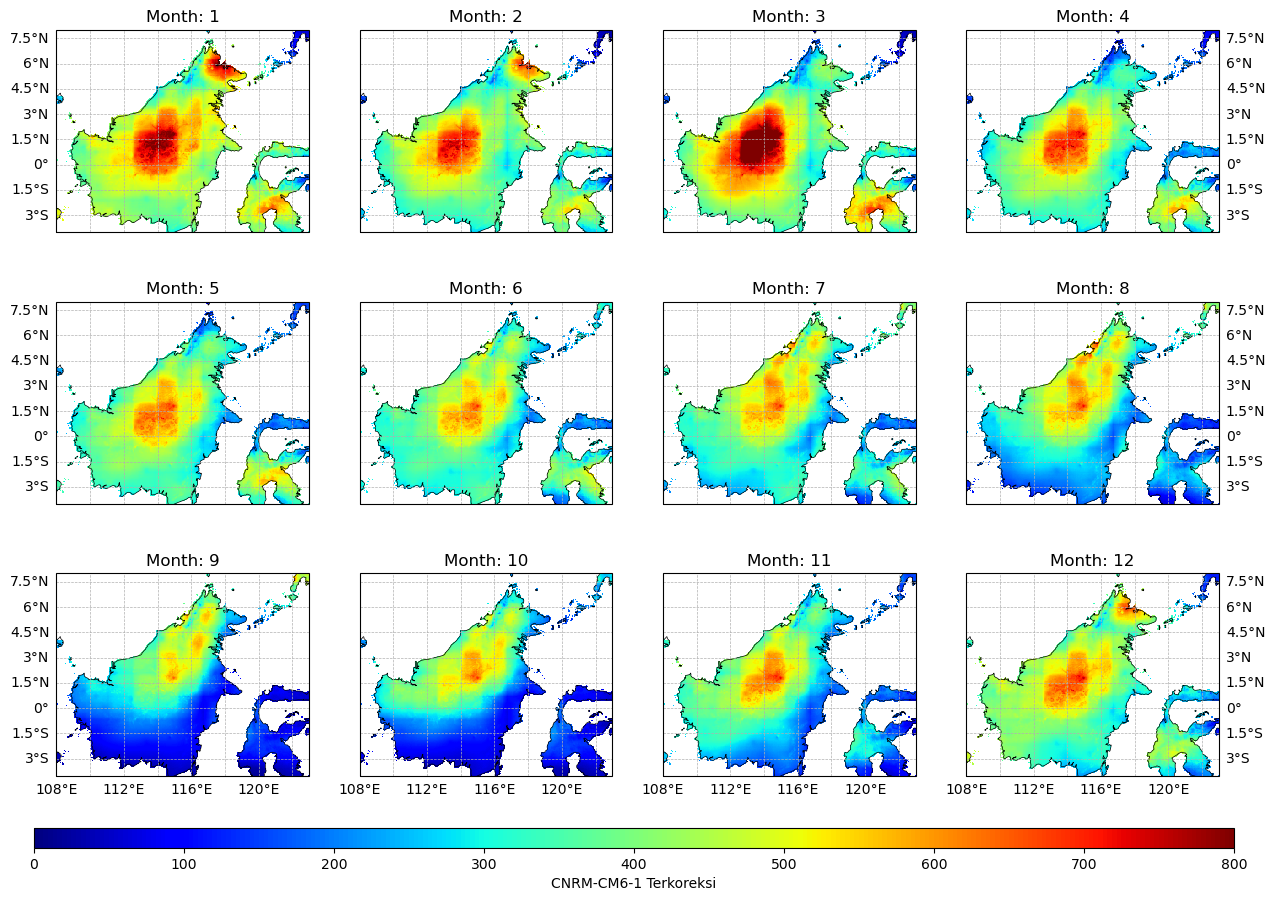

In [97]:
create_clim_plot(resample_bsl_corrected_monthly_mean, 'CNRM-CM6-1 Terkoreksi')

/Users/agungbaruna/miniconda3/envs/wrf/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


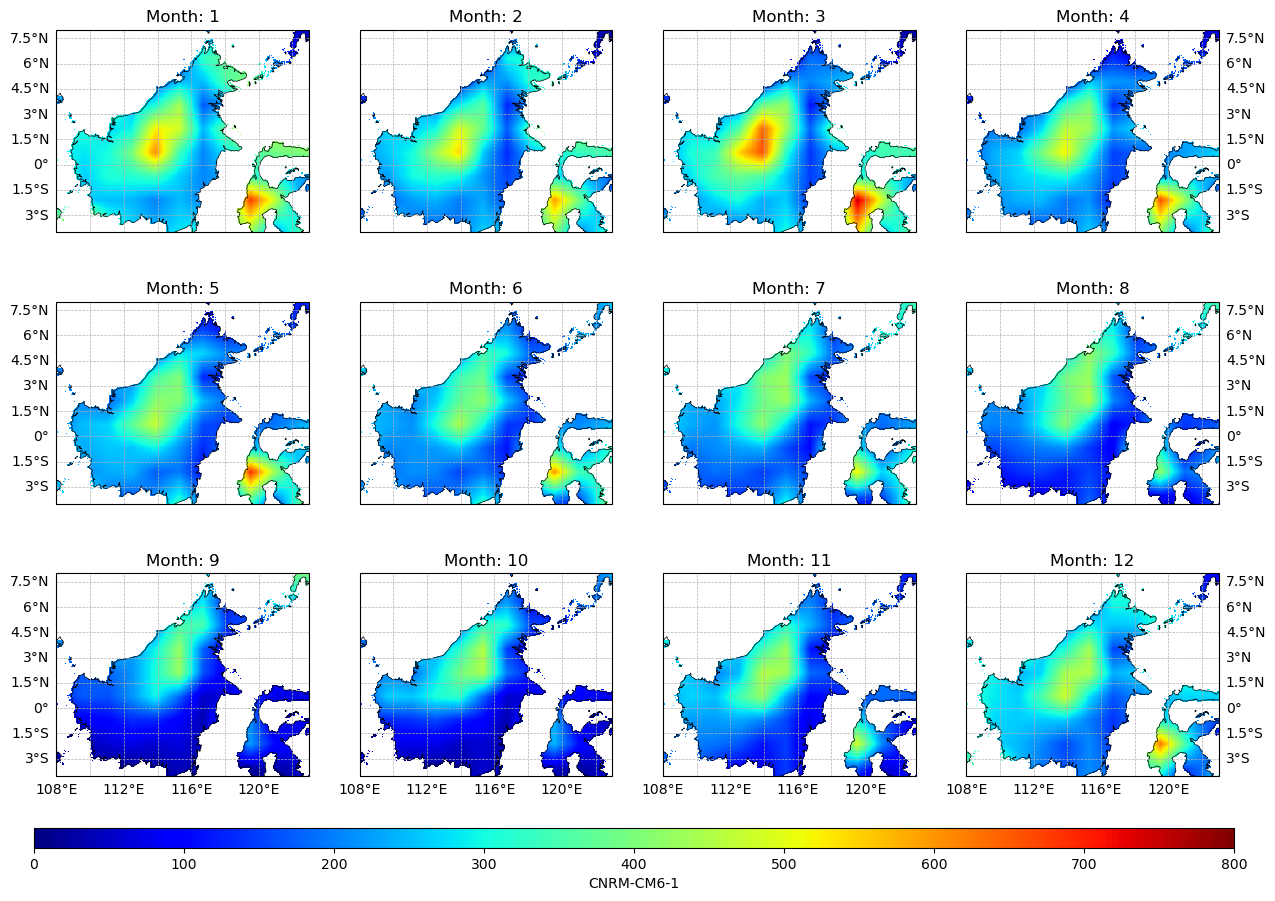

In [113]:
create_clim_plot(resample_bsl_monthly_mean, 'CNRM-CM6-1')

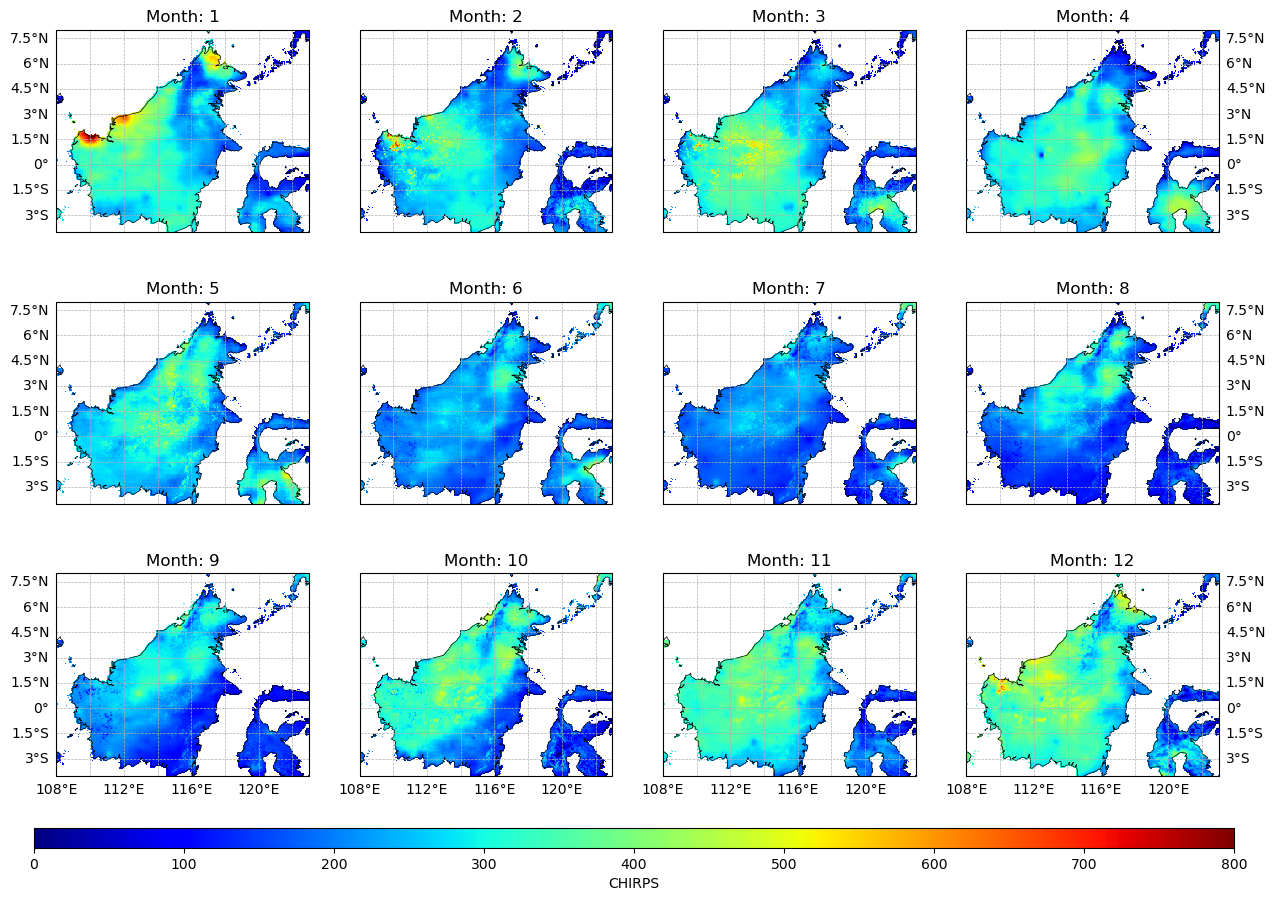

In [100]:
create_clim_plot(chp_monthly_mean, 'CHIRPS')